In [1]:
pip install --upgrade langchain langgraph langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.0/662.0 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.35
    Uninstalling langchain-c

# The Imports

In [2]:
import os
from langchain.schema import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
import re
from langchain_openai import ChatOpenAI

In [3]:
# This line sets an environment variable to store the API key.
os.environ['OPENROUTER_API_KEY'] = "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"

# Defining the State 

In [4]:
class TravelState(TypedDict):
    user_query: str
    selected_destination: str
    trip_itinerary: List[str]
    estimated_cost: float
    user_budget: float

# The Memory Class
This class is a simple memory system for the chat, it helps the AI to remember the last few things the user or system said.

In [6]:
class AgentMemory:
    def __init__(self):
        self.chat_log = []
    
    def update(self, message: str):
        self.chat_log.append(message)
    
    def get_context(self, n=5):
        return "\n".join(self.chat_log[-n:])

memory = AgentMemory()

In [ ]:
# LLM Configuration
def get_llm(model: str = "anthropic/claude-3-haiku", temp: float = 0.2):
    return ChatOpenAI(
        openai_api_key=os.environ['OPENROUTER_API_KEY'],
        openai_api_base="https://openrouter.ai/api/v1",
        model=model,
        temperature=temp,
        max_retries=3,
        timeout=30
    )

In [ ]:
# Agent 1: Destination Confirmation
def recommend_destination(state: TravelState) -> TravelState:
    city_match = re.search(r"City: (.*?)\. Interests:", state['user_query'])
    if city_match:
        city = city_match.group(1).strip()
        if city and len(city.split()) < 4:
            memory.update(f"Confirmed destination: {city}")
            return {**state, "selected_destination": city}
    
    prompt = f"""User interests: {state['user_query']}
    Budget: ${state['user_budget']}
    Should we recommend a specific city? Only if user didn't specify one."""
    
    llm = get_llm("gpt-3.5-turbo", 0.2)
    response = llm.invoke([
        SystemMessage(content="Only recommend cities if the user didn't specify one."),
        HumanMessage(content=prompt)
    ]).content
    
    if "no" in response.lower():
        return state
    
    destination = response.split(":")[-1].split(".")[0].strip()
    memory.update(f"Recommended: {destination}")
    return {**state, "selected_destination": destination}

In [ ]:
# Agent 2: Itinerary Planner
def plan_itinerary(state: TravelState) -> TravelState:
    if not state["selected_destination"]:
        raise ValueError("No destination selected!")
    prompt = f"""Create a 3-day itinerary EXCLUSIVELY for {state['selected_destination']}.
    ABSOLUTELY DO NOT SUGGEST OTHER CITIES.
    User interests: {state['user_query']}
    Budget: ${state['user_budget']}
    Requirements:
    1. Focus ONLY on {state['selected_destination']}
    2. Provide detailed daily plans
    3. Never mention other cities"""
    
    llm = get_llm("gpt-3.5-turbo", 0.2)
    itinerary = llm.invoke([
        SystemMessage(content="You are a precise travel planner who strictly follows destination requirements."),
        HumanMessage(content=prompt)
    ]).content
    
    memory.update(f"Itinerary for {state['selected_destination']}")
    return {**state, "trip_itinerary": [itinerary]}

In [ ]:
# Agent 3: Cost Estimator
def estimate_expenses(state: TravelState) -> TravelState:
    prompt = f"""Calculate total cost for this {state['selected_destination']} trip:
    Itinerary: {state['trip_itinerary'][0]}
    Budget: ${state['user_budget']}
    Return ONLY the format: TOTAL COST: $X,XXX"""
    
    llm = get_llm("mistralai/mixtral-8x7b-instruct", 0.2)
    response = llm.invoke([
        SystemMessage(content="You are a precise travel cost estimator."),
        HumanMessage(content=prompt)
    ]).content
    
    cost_match = re.search(r"\$([\d,]+)", response.replace(",", ""))
    cost = float(cost_match.group(1)) if cost_match else state['user_budget'] * 0.7
    memory.update(f"Estimated cost: ${cost}")
    return {**state, "estimated_cost": cost}

In [ ]:
# Agent 4: Real-Time Travel Assistant
def real_time_assistant(state: TravelState, user_message: str) -> str:
    prompt = f"""You are a real-time travel assistant for a trip to {state['selected_destination']}.
The user may ask about directions, places to eat, nearby attractions, transport options, or emergency tips.
Be friendly, helpful, and context-aware.

Chat History:
{memory.get_context()}

User Message: {user_message}
"""
    llm = get_llm("gpt-3.5-turbo", 0.2)
    response = llm.invoke([
        SystemMessage(content="You are a helpful real-time travel assistant."),
        HumanMessage(content=prompt)
    ]).content
    memory.update(f"User asked: {user_message}\nAssistant replied: {response}")
    return response

In [12]:
# Build LangGraph Workflow
def build_workflow():
    workflow = StateGraph(TravelState)
    workflow.add_node("recommend_dest", recommend_destination)
    workflow.add_node("plan_trip", plan_itinerary)
    workflow.add_node("calculate_cost", estimate_expenses)
    workflow.set_entry_point("recommend_dest")
    workflow.add_edge("recommend_dest", "plan_trip")
    workflow.add_edge("plan_trip", "calculate_cost")
    workflow.add_edge("calculate_cost", END)
    return workflow.compile()

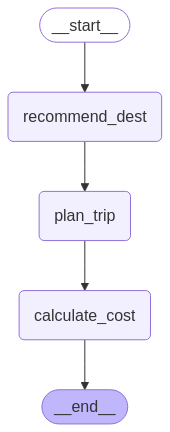

In [13]:
build_workflow()

In [ ]:
# Travel Plan Generation Function
def interactive_travel_planner(city: str, interests: str, budget: float):
    initial_state = {
        "user_query": f"City: {city.strip()}. Interests: {interests.strip()}.",
        "selected_destination": city.strip(),
        "trip_itinerary": [],
        "estimated_cost": 0.0,
        "user_budget": budget
    }
    try:
        travel_planner = build_workflow()
        final_state = travel_planner.invoke(initial_state)
        output = f"""
## Travel Plan for {final_state['selected_destination']}

### Itinerary:
{final_state['trip_itinerary'][0]}

### Estimated Cost: ${final_state['estimated_cost']:.2f}
"""
        if final_state['estimated_cost'] > budget:
            output += f"\nNote: This exceeds your budget by ${final_state['estimated_cost'] - budget:.2f}"
        elif final_state['estimated_cost'] < budget * 0.9:
            output += f"\nYou'll save ${budget - final_state['estimated_cost']:.2f} under your budget!"
        return output
    except Exception as e:
        return f"Error creating plan: {str(e)}"

In [2]:
#main
if __name__ == "__main__":
    city = input("Enter destination city: ")
    interests = input("Enter your interests (comma-separated): ")
    budget = float(input("Enter your budget ($): "))

    print("\n Generating your travel plan...\n")
    plan = interactive_travel_planner(city, interests, budget)
    print(plan)

    while True:
        user_msg = input("\nAsk your Real-Time Travel Assistant (or type 'exit' to quit): ")
        if user_msg.lower() == "exit":
            break
        response = real_time_assistant(
            {
                "user_query": f"City: {city.strip()}. Interests: {interests.strip()}.",
                "selected_destination": city.strip() or "your destination",
                "trip_itinerary": [],
                "estimated_cost": 0.0,
                "user_budget": budget
            },
            user_msg
        )
        print(f"\nAssistant: {response}")


Enter destination city:  cairo
Enter your interests (comma-separated):  food, music, art, history
Enter your budget ($):  3000



📋 Generating your travel plan...


## Travel Plan for cairo

### Itinerary:
Day 1:
- Morning: Start your day with a visit to the Egyptian Museum to explore the history and art of ancient Egypt. Don't miss the treasures of Tutankhamun.
- Lunch: Enjoy a traditional Egyptian meal at Felfela Restaurant, known for its delicious falafel and kebabs.
- Afternoon: Visit the Cairo Citadel and explore the historic Saladin Citadel, which offers panoramic views of the city.
- Evening: Head to El Sawy Culture Wheel for an evening of live music performances showcasing traditional and contemporary Egyptian music.

Day 2:
- Morning: Begin your day with a visit to the iconic Giza Pyramids and the Sphinx. Consider taking a camel ride around the pyramids for a unique experience.
- Lunch: Have lunch at Naguib Mahfouz Cafe in Khan El Khalili, a historic market area, and try traditional Egyptian dishes.
- Afternoon: Explore Khan El Khalili market for shopping and immerse yourself in the vibrant atmosphere o


Ask your Real-Time Travel Assistant (or type 'exit' to quit):  best restaurants nearby?



Assistant: For some of the best dining experiences in Cairo, here are a few recommendations:

1. **Naguib Mahfouz Cafe & Restaurant**: Located in Khan El Khalili, this restaurant offers traditional Egyptian cuisine in a historic setting.

2. **Sequoia**: Enjoy delicious Mediterranean dishes with a stunning view of the Nile River at this upscale restaurant.

3. **Kazaz**: Known for its authentic Egyptian dishes, Kazaz is a popular spot for locals and tourists alike.

4. **Andrea El Mariouteya**: This restaurant offers a unique dining experience in a traditional Egyptian countryside setting.

5. **Taboula**: If you're in the mood for Lebanese cuisine, Taboula is a great choice with its tasty dishes and cozy atmosphere.

Feel free to let me know if you need more recommendations or have any specific preferences!



Ask your Real-Time Travel Assistant (or type 'exit' to quit):  best holiday destinations



Assistant: When it comes to holiday destinations, Cairo itself has a lot to offer in terms of history, culture, and experiences. However, if you're looking for other destinations to explore during your trip, here are some recommendations:

1. **Luxor**: Known as the world's greatest open-air museum, Luxor is home to the stunning Valley of the Kings, Karnak Temple, and Luxor Temple.

2. **Aswan**: Explore the beautiful Nile River, visit the Philae Temple, and take a traditional felucca ride in Aswan.

3. **Alexandria**: Experience the Mediterranean charm of Alexandria with its historic sites like the Citadel of Qaitbay, Bibliotheca Alexandrina, and Pompey's Pillar.

4. **Dahab**: If you're a fan of beach destinations, consider visiting Dahab for its laid-back vibe, great diving spots, and the beautiful Blue Hole.

5. **Siwa Oasis**: For a more off-the-beaten-path experience, head to the Siwa Oasis to explore its unique culture, hot springs, and the ancient Oracle Temple of Amun.

Each 


Ask your Real-Time Travel Assistant (or type 'exit' to quit):  exit
